<a href="https://colab.research.google.com/github/Gonzalo-Ortega/Behavioral-Boxes-GUI/blob/master/Analysis_Gonzalo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports
---

Usefull python libraries:

- Matplotlib: Plotting and data visualization.
- Pandas: Data management. Is most commonly used for data wrangling and data manipulation purposes.
- NumPy: Used to create arrays or matrices that can be applied to DL or ML models.

In [2]:
# Data processing
import pandas as pd
import numpy as np

from scipy.stats import binom
from scipy.special import comb

# Figures
import matplotlib.pyplot as plt
import matplotlib.tri as tri

# Data preprocesing and modeling
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import AffinityPropagation
import sklearn.metrics as skl

# Others
import os
import fnmatch
import cv2
import re
import random

from google.colab import drive
from google.colab import files
from typing import List, Tuple


# Analysis functions
---


## Load data functions

In [3]:
def get_video_paths(data_path: str):
  parts = data_path.split('/')
  folder_path = '/'.join(parts[:-1])
  filename = parts[-1].split('_beh-CROPDLC')[0]
  video_path_top = f'{folder_path}/{filename}_beh-CROP.avi'
  video_path_lateral = f'{folder_path}/{filename}_beh-CROP1.avi'
  return video_path_top, video_path_lateral

def load_paths(dir_path):
  h5_paths_top = []
  h5_paths_lateral = []
  video_paths_top = []
  video_paths_lateral = []
  for dirpath, dirs, files in os.walk(dir_path):
    for filename in fnmatch.filter(files, '*CROPDLC_resnet50_DLC_after_injJan5shuffle1_500000.h5'):
      h5_paths_top.append(os.path.join(dirpath, filename))

  for dirpath, dirs, files in os.walk(dir_path):
    for filename in fnmatch.filter(files, '*CROP1DLC_resnet50_DLC-beh-after-inj-lateralJan7shuffle1_600000.h5'):
      h5_paths_lateral.append(os.path.join(dirpath, filename))

  for path in h5_paths_top:
    video_path_top, video_path_lateral = get_video_paths(path)
    video_paths_top.append(video_path_top)
    video_paths_lateral.append(video_path_lateral)
  return h5_paths_top, h5_paths_lateral, video_paths_top, video_paths_lateral

def load_raw_data(h5_paths_top, h5_paths_lateral):
  data_top = []
  data_lateral = []
  for path in h5_paths_top:
    data_top.append(pd.read_hdf(path, header = [1,2,3]))

  for path in h5_paths_lateral:
    data_lateral.append(pd.read_hdf(path, header = [1,2,3]))

  for data in data_top:
    data.columns = list(data.columns.get_level_values(1) + data.columns.get_level_values(2))

    # Invert Y axis:
    data.loc[:, data.columns[data.columns.str.endswith('y')]] = Y_RESOLUTION - data.loc[:, data.columns[data.columns.str.endswith('y')]]

    # Rotate 90 degrees clockwise:
    labels_to_rotate = ['Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
                        'Back_1', 'Back_2', 'Back_3', 'Back_4',
                        'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4']
    for label in labels_to_rotate:
      data = rotate_90_clockwise(data, label)

  for data in data_lateral:
    data.columns = list(data.columns.get_level_values(1) + data.columns.get_level_values(2))

    # Invert Y axis:
    data.loc[:, data.columns[data.columns.str.endswith('y')]] = Y_RESOLUTION - data.loc[:, data.columns[data.columns.str.endswith('y')]]

  return data_top, data_lateral

def rotate_90_clockwise(data, label='') -> pd.DataFrame:
  """
  Rotates all poits from the desired data colum pair (x and y) 90º clockwise to
  align the top view data with the lateral view data.

  Parameters:
  - data (pd.DataFrame): Data to rotate.
  - label (str): Name of the colomns to rotate, without the last 'x' or 'y'.

  Returns:
  - data (pd.DataFrame): Data with the updated rotated column.
  """
  centered_x = data[label + 'x'] - BOX_CENTER['x']
  centered_y = data[label + 'y'] - BOX_CENTER['y']

  coordinates = np.array([centered_x, centered_y])
  rotation_matrix = np.array([[0, 1], [-1, 0]])
  rotated_x, rotated_y = np.dot(rotation_matrix, coordinates)

  data[label + 'x'] = rotated_x + BOX_CENTER['x']
  data[label + 'y'] = rotated_y + BOX_CENTER['y']
  return data

def save_data(data_top, data_lateral):
  for i, df in enumerate(data_top):
    df.to_csv(f'{PROCESSED_DATA_TOP_PATH}/data-top-{i}.csv')
  for i, df in enumerate(data_lateral):
    df.to_csv(f'{PROCESSED_DATA_LATERAL_PATH}/data-lateral-{i}.csv')

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

def load_data(path):
  data_dfs = []
  file_names = sorted(os.listdir(path))
  for file_name in file_names:
    file_path = os.path.join(path, file_name)
    print(f'Loaded file: {file_name}')
    df = pd.read_csv(file_path)
    data_dfs.append(df)
  return data_dfs

## Auxiliary functions

In [4]:
def info_from_path(video_path) -> dict():
    # Extract Mouse number, date, and video type from the path using regular expressions
    match = re.search(r'Mouse(\d+)_([\d-]+)_.*?beh-(CROP|CROP1)\.avi', video_path)
    if match:
        mouse_number = match.group(1)
        date = match.group(2)
        video_format = 'Top' if match.group(3) == 'CROP' else 'Lateral'
        info_dict = {
            'MouseNumber': mouse_number,
            'Date': date,
            'VideoFormat': video_format
        }
        return info_dict

def get_frame_at_time(video_path, minute, second):
  # Open the video file
  cap = cv2.VideoCapture(video_path)

  # Calculate the frame position based on time
  frame_position = int((minute * 60 + second) * cap.get(cv2.CAP_PROP_FPS))

  # Set the frame position
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame_position)

  # Read the frame at the specified time
  ret, frame = cap.read()

  # Release the video capture object
  cap.release()

  return frame

def get_frame(video_path, frame):
  # Open the video file
  cap = cv2.VideoCapture(video_path)

  # Set the frame position
  cap.set(cv2.CAP_PROP_POS_FRAMES, frame)

  # Read the frame at the specified time
  ret, frame = cap.read()

  # Release the video capture object
  cap.release()

  return frame

def get_mouse_numbers() -> List[int]:
  """
  Gets a list with all the mouse numbers.
  """
  mouse_numbers_list = []
  for path in VIDEO_PATHS_TOP:
    info = info_from_path(path)
    mouse_numbers_list.append(int(info['MouseNumber']))
  return mouse_numbers_list

def get_video_dates() -> List[str]:
  """
  Gets a list with all the video dates.
  """
  video_dates_list = []
  for path in VIDEO_PATHS_TOP:
    info = info_from_path(path)
    video_dates_list.append(info['Date'])
  return video_dates_list

def get_data_frame_latex(data_frame: pd.DataFrame) -> str:
  return data_frame.head(10).to_latex()

def download_figures_zip():
  !zip -r figures.zip $FIGURES_PATH
  files.download('figures.zip')


## Preprocessing funcions

In [5]:
def filter_data(data: pd.DataFrame, desired_likelihood: float) -> pd.DataFrame:
  """
  Filters video data removing points whose likelihooed is less than desired and
  adding NaN (np.nan) to its values instead.

  Parameters:
  - data (pd.DataFrame): Data to filter.
  - desired_likelihood (float): Min likelihood each valid point should have.

  Returns:
  - filtered_data (pd.DataFrame): Copy of the original data with not likely
    values changed by NaN (np.nan).
  """

  filtered_data = data.copy()

  parts = [
      'Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
      'Back_1', 'Back_2', 'Back_3', 'Back_4',
      'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4',
      'Paw_left', 'Paw_right'
  ]

  for part in parts:
      likelihood_column = f'{part}likelihood'

      if likelihood_column in filtered_data.columns:
        x_column = f'{part}x'
        y_column = f'{part}y'

        mask = filtered_data[likelihood_column] < desired_likelihood
        filtered_data.loc[mask, [x_column, y_column]] = np.nan

  return filtered_data

def add_head_mean(data: pd.DataFrame) -> pd.DataFrame:
  """
  Makes a mean with the valid values from the mouse head and adds the
  'Head_meanx' and 'Head_meany' columns to the pd.DataFrame.
  """
  parts = ['Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck']

  x_coords = np.array([data[f'{part}x'] for part in parts])
  y_coords = np.array([data[f'{part}y'] for part in parts])

  x_mean = np.nanmean(x_coords, axis=0)
  y_mean = np.nanmean(y_coords, axis=0)

  data['Head_meanx'] = x_mean
  data['Head_meany'] = y_mean

  return data

def add_back_mean(data: pd.DataFrame) -> pd.DataFrame:
  """
  Makes a mean with the back values and add the corresponding values to the
  dataframe.
  """
  parts = ['Neck', 'Back_1', 'Back_2', 'Back_3', 'Back_4']

  x_coords = np.array([data[f'{part}x'] for part in parts])
  y_coords = np.array([data[f'{part}y'] for part in parts])

  x_mean = np.nanmean(x_coords, axis=0)
  y_mean = np.nanmean(y_coords, axis=0)

  data['Back_meanx'] = x_mean
  data['Back_meany'] = y_mean

  return data

def add_tailbase_mean(data: pd.DataFrame) -> pd.DataFrame:
  """
  Makes a mean with the tail base values and add the corresponding values to the
  dataframe.
  """
  parts = ['Back_4', 'Tail_1']

  x_coords = np.array([data[f'{part}x'] for part in parts])
  y_coords = np.array([data[f'{part}y'] for part in parts])

  x_mean = np.nanmean(x_coords, axis=0)
  y_mean = np.nanmean(y_coords, axis=0)

  data['Tailbase_meanx'] = x_mean
  data['Tailbase_meany'] = y_mean

  return data

def interpolate_data(filtered_data: pd.DataFrame) -> pd.DataFrame:
  """
  Interpolates NaN (np.nan) values.
  """

  interpolated_data = filtered_data.copy()

  parts = [
      'Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
      'Back_1', 'Back_2', 'Back_3', 'Back_4',
      'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4',
      'Paw_left', 'Paw_right',
      'Head_mean', 'Back_mean', 'Tailbase_mean'
  ]

  for part in parts:
    x_column = f'{part}x'
    y_column = f'{part}y'

    if x_column in interpolated_data.columns:
      x_coords = np.array(filtered_data[x_column], dtype=float)
      y_coords = np.array(filtered_data[y_column], dtype=float)

      # Find indices of NaN values
      nan_indices_x = np.isnan(x_coords)
      nan_indices_y = np.isnan(y_coords)

      non_nan_indices = np.arange(len(x_coords))

      # Interpolate NaN values
      if not non_nan_indices[~nan_indices_x].size == 0:
        x_coords[nan_indices_x] = np.interp(non_nan_indices[nan_indices_x], non_nan_indices[~nan_indices_x], x_coords[~nan_indices_x])
        y_coords[nan_indices_y] = np.interp(non_nan_indices[nan_indices_y], non_nan_indices[~nan_indices_y], y_coords[~nan_indices_y])

      interpolated_data[x_column] = x_coords
      interpolated_data[y_column] = y_coords

  return interpolated_data

def check_nan_percentages(part, likelihood):
  part = part + 'likelihood'
  for i in range(len(VIDEO_PATHS_LATERAL)):
    nan_counter = 0
    for row in data_lateral[i][part]:
      if row < likelihood:
        nan_counter += 1

    total = len(filtered_data_lateral[i][part])
    nan_percentage = nan_counter/total*100
    print(f'Video {i}: {nan_percentage:.2f} %')

def filter_and_interpolate(data, desired_likelihood):
  filtered_data = []
  interpolated_data = []

  for data_frame in data:
    filtered_data_frame = filter_data(data_frame, desired_likelihood)
    filtered_data_frame = add_head_mean(filtered_data_frame)
    filtered_data_frame = add_back_mean(filtered_data_frame)
    filtered_data_frame = add_tailbase_mean(filtered_data_frame)
    filtered_data.append(filtered_data_frame)

    interpolated_data_frame = interpolate_data(filtered_data_frame)
    interpolated_data.append(interpolated_data_frame)

  return filtered_data, interpolated_data


## Rearing functions

In [6]:
FRAME_RATE = 20
MIN_FRAMES = 5

def get_rearing_intervals(data_frame: pd.DataFrame) -> List[Tuple[int, int]]:
  """
  Gets a list of time intervals where the mouse is rearing in the format:
  '(start_frame, end_frame)'
  """

  # Check frames where trayectory goes out of the box limits.
  out_of_box_frames = set()
  for index, x in enumerate(data_frame['Head_meanx']):
    if x < BOX_TOP['x'][0] or x > BOX_TOP['x'][1]:
      out_of_box_frames.add(index)

  for index, y in enumerate(data_frame['Head_meany']):
    if y < BOX_TOP['y'][0] or y > BOX_TOP['y'][3]:
      out_of_box_frames.add(index)

  # Group frames into intervals:
  rearing_intervals_list = []
  start_frame = 0
  last_frame = 0
  out_of_box_frames = list(out_of_box_frames)
  out_of_box_frames.sort()
  for frame in out_of_box_frames:
    if frame != last_frame + 1:
      rearing_intervals_list.append((start_frame, last_frame))
      start_frame = frame
      last_frame = frame
    else:
      last_frame = frame

  # Filter by minumun interval frame amount:
  rearing_intervals_list = [
      (start, end)
      for start, end in rearing_intervals_list if end - start > MIN_FRAMES
  ]

  return rearing_intervals_list

def get_rearing_frames(data_frame: pd.DataFrame) ->  List[Tuple[int, int]]:
  """
    Gets the mid frame of each rearing interval with the format:
    '(min, sec)'
  """
  rearing_intervals = get_rearing_intervals(data_frame)
  rearing_frames = [
      ((start + end)/2 // FRAME_RATE // 60, (start + end)/2 / FRAME_RATE % 60)
      for start, end in rearing_intervals if end - start > MIN_FRAMES
  ]
  return rearing_frames

def get_rearing_times(data_top: List[pd.DataFrame]) -> List[float]:
  """
    Gets a list with the total time the mouse rear in each video.
  """
  rearing_times_list = []
  for data_frame in data_top:
    rearing_intervals = get_rearing_intervals(data_frame)
    total_time = 0
    for start, end in rearing_intervals:
      total_time += (end - start) / FRAME_RATE
    rearing_times_list.append(total_time)
  return rearing_times_list

def get_rearing_amounts(data_top: List[pd.DataFrame]) -> List[int]:
  """
    Gets a list with the number of times the mouse rear in each video.
  """
  rearing_amounts_list = []
  for data_frame in data_top:
    rearing_intervals = get_rearing_intervals(data_frame)
    rearing_amounts_list.append(len(rearing_intervals))
  return rearing_amounts_list


## Body triangulation functions

In [7]:
def triangulate(data, frame):
  x = []
  y = []
  parts = [
        'Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
        'Back_1', 'Back_2', 'Back_3', 'Back_4',
        'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4']
  for part in parts:
   x.append(data[f'{part}x'][frame])
   y.append(data[f'{part}y'][frame])

  triangles = np.array([
    [0, 1, 2],
    [0, 1, 3],
    [2, 3, 1],
    [2, 3, 4],
    [2, 3, 8]
  ])
  triangulation = tri.Triangulation(x, y, triangles)

  return x, y, triangulation

def triangulate_lateral(data, frame):
  x = []
  y = []
  parts = [
        'Nose', 'Head', 'Ear_left', 'Ear_right', 'Neck',
        'Back_1', 'Back_2', 'Back_3', 'Back_4',
        'Tail_1', 'Tail_2', 'Tail_3', 'Tail_4',
        'Paw_left', 'Paw_right']
  for part in parts:
   x.append(data[f'{part}x'][frame])
   y.append(data[f'{part}y'][frame])

  triangles = np.array([
    [0, 1, 2],
    [0, 1, 3],
    [2, 3, 1],
    [2, 3, 4],
    [2, 3, 8]
  ])
  triangulation = tri.Triangulation(x, y, triangles)

  return x, y, triangulation


## Speed, aceleration & angles functions

In [8]:
def add_time(data: pd.DataFrame):
  frame_rate = 20
  time_intervals = len(data)
  total_time = time_intervals / frame_rate
  time = np.linspace(0, total_time, time_intervals)

  data['Time'] = time
  return data

def add_speed(data: pd.DataFrame):
  dx = np.diff(data['Back_meanx'])
  dy = np.diff(data['Back_meany'])
  speed = np.sqrt(dx**2 + dy**2)
  speed = np.append(speed, speed[-1])
  speed[0] = speed[1]

  data['Speed'] = speed
  return data

def add_acceleration(data: pd.DataFrame):
  acceleration = np.diff(data['Speed'])
  acceleration = np.append(acceleration, acceleration[-1])
  acceleration[0] = acceleration[1]

  data['Acceleration'] = acceleration
  return data

def fit_line(points):

    x_coords, y_coords = zip(*points)
    x_mean = np.mean(x_coords)
    y_mean = np.mean(y_coords)

    # Calculate the slope (m) using the formula: m = Σ((x - x_mean)*(y - y_mean)) / Σ((x - x_mean)^2)
    numerator = sum((x - x_mean) * (y - y_mean) for x, y in points)
    denominator = sum((x - x_mean) ** 2 for x, _ in points)


    slope = numerator / denominator

    intercept = y_mean - slope * x_mean

    p1 = project_point_onto_line(points[0], slope, intercept)
    p2 = project_point_onto_line(points[2], slope, intercept)
    v = p2 - p1

    return v

def project_point_onto_line(point, slope, intercept):
    x, y = point
    x_proj = (x + slope * y - slope * intercept) / (1 + slope ** 2)
    y_proj = (slope * (x + slope * y - slope * intercept) + intercept) / (1 + slope ** 2)
    return np.array([x_proj, y_proj])

def add_angles(data: pd.DataFrame):
  head_points = ['Nose', 'Head', 'Neck']
  back_points = ['Neck', 'Back_1', 'Back_2', 'Back_3', 'Back_4']

  angle_list = []
  for index, row in data.iterrows():
    x = np.array([row[f'{point}x'] for point in head_points])
    y = np.array([row[f'{point}y'] for point in head_points])
    v1 = fit_line(list(zip(x, y)))

    x = np.array([row[f'{point}x'] for point in back_points])
    y = np.array([row[f'{point}y'] for point in back_points])
    v2 = fit_line(list(zip(x, y)))

    angle = np.arctan2(np.linalg.det([v1, v2]), np.dot(v1, v2))
    angle_list.append(np.degrees(angle))

  data['Angle'] = angle_list
  return data

def add_z_strech(data: pd.DataFrame):
  strech = data['Heady'] - data['Back_4y']
  return strech

def get_mean_speeds(data: List[pd.DataFrame]):
  mean_speeds_list = []
  for data_frame in data:
    mean_speeds_list.append(np.mean(data_frame['Speed']))
  return mean_speeds_list

def get_mean_abs_acelerations(data: List[pd.DataFrame]):
  mean_abs_acelerations_list = []
  for data_frame in data:
    mean_abs_acelerations_list.append(np.mean(abs(data_frame['Aceleration'])))
  return mean_abs_acelerations_list

def get_total_times(data: List[pd.DataFrame]):
  total_times_list = []
  for data_frame in data:
    total_times_list.append(data_frame['Time'].iloc[-1])
  return total_times_list


## Similariy and affinity propagation clustering functions

In [9]:
def get_features_hists(features: List[float], bins: List[float], bean_frames: int):
    num_features = len(features)
    num_chunks = num_features // bean_frames
    hist_list = np.empty((num_chunks, len(bins) - 1))

    for i in range(num_chunks):
        chunk = features[i * bean_frames : (i + 1) * bean_frames]
        hist_list[i], _ = np.histogram(chunk, bins=bins)
        hist_list[i] /= bean_frames

    return hist_list

def get_earth_movers_distance(index: int, hists: List[np.ndarray]) -> np.ndarray:
    p = hists[index]
    emd_arr = np.zeros(len(hists))

    for i, q in enumerate(hists):
        emd = np.sum(np.abs(np.cumsum(p) - np.cumsum(q)))
        emd_arr[i] = emd / len(p)

    return emd_arr

def get_speed_similarity(index, df_top, _, bean_frames):
  bins = [0, 5, 100]
  hists = get_features_hists(df_top['Speed'], bins, bean_frames)
  emds = get_earth_movers_distance(index, hists)
  s = -(emds)**2
  return s

def get_acceleration_similarity(index, df_top, _, bean_frames):
  acceleration_bins = [0, 5, 100]
  acceleration_hists = get_features_hists(
      abs(df_top['Acceleration']), acceleration_bins, bean_frames)
  acceleration_emds = get_earth_movers_distance(index, acceleration_hists)
  s = -(acceleration_emds)**2
  return s

def get_similarity(index, df_top, df_lateral, bean_frames):
  angle_bins = [-180, -45, 45, 180]
  angle_hists = get_features_hists(
      df_top['Angle'], angle_bins, bean_frames)
  angle_emds = get_earth_movers_distance(index, angle_hists)

  acceleration_bins = [0, 5, 100]
  acceleration_hists = get_features_hists(
      abs(df_top['Acceleration']), acceleration_bins, bean_frames)
  acceleration_emds = get_earth_movers_distance(index, acceleration_hists)

  z_strech_bins = [-200, 20, 200]
  z_strech_hists = get_features_hists(
      abs(df_lateral['Strech']), z_strech_bins, bean_frames)
  z_strech_emds = get_earth_movers_distance(index, z_strech_hists)

  s = -((angle_emds + acceleration_emds + z_strech_emds) / 3)**2

  return s

def get_similarity_matrix(df_top, df_lateral, get_similarity_func, bean_frames=5):
  size = len(df_top) // bean_frames
  mat = np.zeros((size, size))
  for i in range(size):
    row = get_similarity_func(i, df_top, df_lateral, bean_frames)
    mat[i] = row
  return mat

def sort_similarity_matrix_by_cluster(similarity_mat, clusters):
  cluster_amount = len(set(clusters))
  points_amount = len(similarity_mat)
  aux_mat = np.zeros((points_amount, points_amount))

  i = 0
  for cluster in range(cluster_amount):
    for point in range(points_amount):
      if clusters[point] == cluster:
        aux_mat[i, :] = similarity_mat[point, :]
        i += 1

  i = 0
  sorted_mat = np.zeros((points_amount, points_amount))
  for cluster in range(cluster_amount):
    for point in range(points_amount):
      if clusters[point] == cluster:
        sorted_mat[:, i] = aux_mat[:, point]
        i += 1

  return sorted_mat

def get_similarity_mats(data_top_dfs, data_lateral_dfs):
  similarity_mats = []
  for i in range(len(data_top_dfs)):
    try:
      mat = get_similarity_matrix(data_top_dfs[i], data_lateral_dfs[i], bean_frames=5)
      similarity_mats.append(mat)
      np.save(f'{SIMILARITY_MAT_PATH}/sililarity-{i}.npy', mat)
      print(f'Saved matrix: {i}')
    except Exception as e:
      print(f'Error computing matrix {i}: {e}')
  return similarity_mats

def save_similarity_mats(similarity_mats):
  for i, mat in enumerate(similarity_mats):
    np.save(f'{SIMILARITY_MAT_PATH}/sililarity-{i}.npy', mat)

def load_similarity_mats():
  mats = []
  for file_name in os.listdir(SIMILARITY_MAT_PATH):
    file_path = os.path.join(SIMILARITY_MAT_PATH, file_name)
    mat = np.load(file_path)
    mats.append(mat)
  return mats

## PCA and agglomerative clustering functions

In [10]:
def initialize_features(data_for_pca):
  features = pd.DataFrame()

  features['Animal_number'] = get_mouse_numbers()[:len(data_for_pca)]
  features['Date'] = get_video_dates()
  features['Rearing_amount'] = get_rearing_amounts(data_for_pca)
  features['Rearing_time'] = get_rearing_times(data_for_pca)
  features['Mean_speed'] = get_mean_speeds(data_for_pca)
  features['Mean_abs_aceleration'] = get_mean_abs_acelerations(data_for_pca)
  features['Total_time'] = get_total_times(data_for_pca)

  return features

def initialize_assignment_check(features: pd.DataFrame) -> pd.DataFrame:
  animals_treatment = pd.read_csv(DATA_PATH + '/Animals_treatment.csv')
  assignment_check = pd.DataFrame()
  assignment_check['Animal_number'] = features['Animal_number']
  return pd.merge(assignment_check, animals_treatment, on='Animal_number')

def check_assigment(assigment_check, assignment):
  map = assigment_check['Treatment'].map({'CONTROL': 1, 'NMDA': 0})
  return (assignment == map).mean()

def compute_features_pca(features) -> Tuple[np.ndarray, PCA]:
  scaler = StandardScaler()
  scaler.fit(features)
  features_scaled = scaler.transform(features)

  pca = PCA()
  pca.fit(features_scaled)
  features_pca = pca.transform(features_scaled)

  return features_pca, pca

def compute_agg_cluster(features_pca):
  agg = AgglomerativeClustering()
  return agg.fit_predict(features_pca)

def compute_random_cluster(features_pca):
  return [random.choice([0, 1]) for _ in range(len(features_pca))]


## Method testing functions

In [11]:
def compute_method_distribution(features: pd.DataFrame, sesions=50, iterations=1000) -> List[float]:
  dist = []
  for i in range(iterations):
    features_sample = features.sample(n=sesions)
    features_to_analyce = features_sample[['Rearing_amount', 'Rearing_time', 'Mean_speed',
                               'Mean_abs_aceleration']]
    features_pca, pca = compute_features_pca(features_to_analyce)
    assignment = compute_agg_cluster(features_pca)
    assignment_check = initialize_assignment_check(features_sample)
    dist.append(check_assigment(assignment_check, assignment))
  return dist

# Figure functions
---

### Trayectory figures

In [11]:
def figure_trayectory(data, video_num, video_paths, time=None):
  if time:
    start = time[0] * 20
    end = time[1] * 20
    data = data[video_num].iloc[start:end]
  else:
    data = data[video_num]

  video_path = video_paths[video_num]
  info = info_from_path(video_path)
  x = data['Head_meanx']
  y = data['Head_meany']
  number = info['MouseNumber']
  date = info['Date']
  format = info['VideoFormat']

  # Interpolated trayectory Figure #
  fig = plt.figure(figsize=(12, 5))
  fig.suptitle(f'{format} trayectory - Video: {video_num}, Mouse: {number}, {date}')

  # Plot 1: Trayectory
  ax1 = fig.add_subplot(121)
  ax1.plot(x, y, label='Position')
  if format == 'Top':
    ax1.plot(BOX_TOP['x'], BOX_TOP['y'], label='Box')
  elif format == 'Lateral':
    ax1.plot(BOX_LATERAL['x'], BOX_LATERAL['y'], label='Box')
  ax1.set_box_aspect(1)
  ax1.spines[['right', 'top']].set_visible(False)
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.legend()

  # Plot 2: Heatmap
  ax2 = fig.add_subplot(122)
  hist = ax2.hist2d(x, y, bins=20)
  cbar = fig.colorbar(hist[3], ax=ax2)
  cbar.set_label('Position frequency')
  ax2.set_box_aspect(1)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')

  fig.savefig(f"{FIGURES_PATH}/trayectory.pdf")

def figure_all_trayectories(data_top, data_lateral):
  # Interpolated trayectory Figure #
  fig = plt.figure(figsize=(12, 5))
  fig.suptitle('All trayectories')

  # Plot 1: All trayectories Top
  ax1 = fig.add_subplot(121)
  for index, data in enumerate(data_top):
    ax1.plot(data['Head_meanx'], data['Head_meany'])

  ax1.plot(BOX_TOP['x'], BOX_TOP['y'], label='Box')
  ax1.set_box_aspect(1)
  ax1.spines[['right', 'top']].set_visible(False)
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.set_title('Top trajectories')
  ax1.legend()

  # Plot 2: All trayectories Lateral
  ax2 = fig.add_subplot(122)
  for data in data_lateral:
    ax2.plot(data['Meanx'], data['Meany'])

  ax2.plot(BOX_LATERAL['x'], BOX_LATERAL['y'], label='Box')
  ax2.set_box_aspect(1)
  ax2.spines[['right', 'top']].set_visible(False)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.set_title('Lateral trajectories')
  ax2.legend()

  fig.savefig(f"{FIGURES_PATH}/all-trayectories.pdf")


### Rearing figures

In [12]:
def figure_rearing_frames(data_top, video_number:int):
  rearing_frames = get_rearing_frames(data_top[video_number])

  i = 0
  for minute, second in rearing_frames:
    fig = plt.figure(figsize=(12, 5))
    i += 1
    frame = get_frame_at_time(VIDEO_PATHS_TOP[video_number], minute, second)
    ax1 = fig.add_subplot(1, 2, 1)
    rotated_frame_top = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)
    ax1.imshow(cv2.cvtColor(rotated_frame_top, cv2.COLOR_BGR2RGB))
    ax1.set_title('Frame {}:{:05.2f}s'.format(int(minute), second))
    ax1.axis('off')

    frame = get_frame_at_time(VIDEO_PATHS_LATERAL[video_number], minute, second)
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax2.axis('off')

    plt.tight_layout()
    fig.savefig(f"{FIGURES_PATH}/rearing-{i}.pdf")


### Triangulation figures

In [13]:
def figure_triangulations_trayectory(data_top, data_lateral):
  fig = plt.figure(figsize=(12, 5))
  fig.suptitle('Triangulation')

  # Plot 1
  ax1 = fig.add_subplot(121)
  for frame in range(1, 5000, 500):
    x, y, triangulation = triangulate(data_top, frame)
    alpha = frame / 5000.0
    ax1.triplot(triangulation, '.--', alpha=alpha)
  ax1.plot(BOX_TOP['x'], BOX_TOP['y'], label='Box')
  ax1.set_box_aspect(1)
  ax1.spines[['right', 'top']].set_visible(False)
  ax1.set_xlabel('X')
  ax1.set_ylabel('Y')
  ax1.legend()

  # Plot 2
  ax2 = fig.add_subplot(122)
  for frame in range(1, 5000, 500):
    x, y, triangulation = triangulate(data_lateral, frame)
    alpha = frame / 5000.0
    ax2.triplot(triangulation, '.--', alpha=alpha)
  ax2.plot(BOX_LATERAL['x'], BOX_LATERAL['y'], label='Box')
  ax2.set_box_aspect(1)
  ax2.spines[['right', 'top']].set_visible(False)
  ax2.set_xlabel('X')
  ax2.set_ylabel('Y')
  ax2.legend()

def figure_triangulation_frame_top(data, video, frame):
  data_frame = data[video]
  frame_img = get_frame(VIDEO_PATHS_TOP[video], frame)
  x, y, triangulation = triangulate(data_frame, frame)

  frame_img = cv2.rotate(frame_img, cv2.ROTATE_90_CLOCKWISE)

  fig = plt.figure(figsize=(12, 5))
  ax1 = fig.add_subplot(121)
  ax1.triplot(triangulation, '.--')
  ax1.plot(x[8:], y[8:], '.--')
  ax1.plot(x[4:9], y[4:9], '.--')

  # o1 = [data_frame['Neckx'][frame], data_frame['Necky'][frame]]
  # o2 = [data_frame['Back_3x'][frame], data_frame['Back_3y'][frame]]

  # ax1.quiver(o1, data_frame['Headx'][frame], data_frame['Heady'][frame])
  # ax1.quiver(o2, data_frame['Neckx'][frame], data_frame['Necky'][frame])


  ax1.plot(BOX_TOP['x'], BOX_TOP['y'])

  ax2 = fig.add_subplot(122)
  ax2.imshow(cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB))

  fig.show()

def figure_triangulation_frame_lateral(data, video, frame):
  data_frame = data[video]
  frame_img = get_frame(VIDEO_PATHS_LATERAL[video], frame)
  x, y, triangulation = triangulate_lateral(data_frame, frame)
  fig = plt.figure(figsize=(12, 5))
  ax1 = fig.add_subplot(121)
  ax1.triplot(triangulation, '.--')

  #for i, txt in enumerate(range(len(x))):
  #  ax1.text(x[i], y[i], f'{txt}', ha='right', va='bottom')

  ax1.plot(x[8:13], y[8:13], '.--')
  ax1.plot(x[4:9], y[4:9], '.--')
  ax1.plot(BOX_LATERAL['x'], BOX_LATERAL['y'])

  ax2 = fig.add_subplot(122)
  ax2.imshow(cv2.cvtColor(frame_img, cv2.COLOR_BGR2RGB))

  fig.show()


### Features figures

In [14]:
def get_figure_data(data: List[pd.DataFrame], video_num: int, time=None):
  if time:
    start = time[0] * 20
    end = time[1] * 20
    data = data[video_num].iloc[start:end]
  else:
    data = data[video_num]

  video_path = VIDEO_PATHS_TOP[video_num]
  info = info_from_path(video_path)
  number = info['MouseNumber']
  date = info['Date']

  fig = plt.figure(figsize=(12, 5))
  ax = fig.add_subplot(111)
  ax.spines[['right', 'top']].set_visible(False)
  return fig, ax, data, number, date

# Speed figures:
def figure_speed_plot(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Speed - Video: {video_num}, Mouse: {number}, {date}')

  ax.plot(data['Time'], data['Speed'])
  ax.set_xlabel('Time [$s$]')
  ax.set_ylabel('Speed [$pixels/s$]')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_speed_hist(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Speed histogram - Video: {video_num}, Mouse: {number}, {date}')

  ax.hist(data['Speed'], bins=100)
  ax.set_xlabel('Speed [$pixels/s$]')
  ax.set_ylabel('Amount')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_speed_dist(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Speed PDF - Video: {video_num}, Mouse: {number}, {date}')

  hist, edges = np.histogram(data['Speed'], bins=100)
  hist = hist / np.sum(hist)
  ax.plot(edges[:-1], hist, marker='', linestyle='-')
  ax.set_xlabel('Speed [$pixels/s$]')
  ax.set_ylabel('Probability')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_speed_mean_dist(data: List[pd.DataFrame], save_name=None):
  fig = plt.figure(figsize=(12, 5))
  ax = fig.add_subplot(111)
  ax.spines[['right', 'top']].set_visible(False)
  fig.suptitle(f'Mean speed PDF')
  hist_list = []
  for data_frame in data:
    if not data_frame['Speed'].isna().sum():
      hist, edges = np.histogram(data_frame['Speed'], bins=100)
      hist_list.append(hist / np.sum(hist))

  hist_mean = np.mean(hist_list, axis=0)
  ax.plot(edges[:-1], hist_mean, marker='', linestyle='-')

  ax.set_xlabel('Acceleration [$pixels/s$]')
  ax.set_ylabel('Probability')

# Acceleration figures:
def figure_acceleration_plot(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Acceleration - Video: {video_num}, Mouse: {number}, {date}')

  ax.plot(data['Time'], data['Acceleration'])
  ax.set_xlabel('Time [$s$]')
  ax.set_ylabel('Acceleration [$pixels/s^2$]')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_acceleration_hist(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Acceleration - Video: {video_num}, Mouse: {number}, {date}')

  ax.hist(data['Acceleration'], bins=100)
  ax.set_xlim(-20, 20)
  ax.set_xlabel('Acceleration [$pixels/s^2$]')
  ax.set_ylabel('Amount')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_acceleration_dist(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Acceleration PDF - Video: {video_num}, Mouse: {number}, {date}')

  hist, edges = np.histogram(np.abs(data['Acceleration']), bins=100)
  hist = hist / np.sum(hist)
  ax.plot(edges[:-1], hist, marker='', linestyle='-')
  ax.set_xlim(-20, 20)
  ax.set_xlabel('Acceleration [$pixels/s^2$]')
  ax.set_ylabel('Probability')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_acceleration_mean_dist(data: List[pd.DataFrame], save_name=None):
  fig = plt.figure(figsize=(12, 5))
  ax = fig.add_subplot(111)
  ax.spines[['right', 'top']].set_visible(False)
  fig.suptitle(f'Mean abs acceleration PDF')
  hist_list = []
  for data_frame in data:
    if not data_frame['Acceleration'].isna().sum():
      hist, edges = np.histogram(data_frame['Acceleration'], bins=100)
      hist_list.append(hist / np.sum(hist))

  hist_mean = np.mean(hist_list, axis=0)
  ax.plot(edges[:-1], hist_mean, marker='', linestyle='-')

  ax.set_xlabel('Acceleration [$pixels/s^2$]')
  ax.set_ylabel('Probability')

# Angles figures:
def figure_angles_plot(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Angles - Video: {video_num}, Mouse: {number}, {date}')

  ax.plot(data['Time'], data['Angle'])
  ax.set_xlabel('Time [$s$]')
  ax.set_ylabel('Angle [$degrees$]')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_angles_hist(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Angles histogram - Video: {video_num}, Mouse: {number}, {date}')

  ax.hist(data['Angle'], bins=100)
  ax.set_xlabel('Angle [$degrees$]')
  ax.set_ylabel('Amount')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_angles_dist(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Anlges PDF - Video: {video_num}, Mouse: {number}, {date}')

  hist, edges = np.histogram(data['Angle'], bins=100)
  hist = hist / np.sum(hist)
  ax.plot(edges[:-1], hist, marker='', linestyle='-')
  ax.set_xlabel('Angle [$degrees$]')
  ax.set_ylabel('Probability')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

# Strech figures:
def figure_z_strech_plot(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Z strech - Video: {video_num}, Mouse: {number}, {date}')

  ax.plot(data['Time'], data['Strech'])
  ax.set_xlabel('Time [$s$]')
  ax.set_ylabel('Strech [$pixels$]')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_z_strech_hist(data: List[pd.DataFrame], video_num: int, time=None, save_name=None):
  fig, ax, data, number, date = get_figure_data(data, video_num, time)
  fig.suptitle(f'Z strech histogram - Video: {video_num}, Mouse: {number}, {date}')

  ax.hist(data['Strech'], bins=100)
  ax.set_xlabel('Strech [$pixels$]')
  ax.set_ylabel('Amount')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_z_strech_dist(data: List[pd.DataFrame], video_num=None, time=None, save_name=None):
  if video_num:
    fig, ax, data, number, date = get_figure_data(data, video_num, time)
    fig.suptitle(f'Z strech PDF - Video: {video_num}, Mouse: {number}, {date}')
    hist, edges = np.histogram(data['Strech'], bins=100)
    hist = hist / np.sum(hist)
    ax.plot(edges[:-1], hist, marker='', linestyle='-')
  else:
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(111)
    ax.spines[['right', 'top']].set_visible(False)
    fig.suptitle(f'Z strech PDF - All videos')
    for data_frame in data:
      if not data_frame['Strech'].isna().sum():
        hist, edges = np.histogram(data_frame['Strech'], bins=100)
        hist = hist / np.sum(hist)
        ax.plot(edges[:-1], hist, marker='', linestyle='-')

  ax.set_xlabel('Strech [$pixels$]')
  ax.set_ylabel('Probability')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

def figure_z_strech_mean_dist(data: List[pd.DataFrame], save_name=None):
  fig = plt.figure(figsize=(12, 5))
  ax = fig.add_subplot(111)
  ax.spines[['right', 'top']].set_visible(False)
  fig.suptitle(f'Mean Z strech PDF')
  hist_list = []
  for data_frame in data:
    if not data_frame['Strech'].isna().sum():
      hist, edges = np.histogram(data_frame['Strech'], bins=100)
      hist_list.append(hist / np.sum(hist))

  hist_mean = np.mean(hist_list, axis=0)
  ax.plot(edges[:-1], hist_mean, marker='', linestyle='-')

  ax.set_xlabel('Strech [$pixels$]')
  ax.set_ylabel('Probability')

  if save_name:
    fig.savefig(f"{FIGURES_PATH}/{save_name}.pdf")

### Similarity figures

In [15]:
def figure_similarity_heat_map(matrix):
  fig = plt.figure(figsize=(5, 5))
  fig.suptitle('Similarity matrix')
  ax = fig.add_subplot(111)
  im1 = ax.imshow(matrix, cmap='jet', interpolation='nearest')
  ax.set_aspect('equal')
  ax.set_xlabel('Time bin j')
  ax.set_ylabel('Time bin i')
  fig.colorbar(im1, ax=ax, fraction=0.04)

def figure_similarity_heat_map_matrices(similarity_mat, sorted_mat):
  fig = plt.figure(figsize=(15, 5))
  fig.suptitle('Similarity matrix')

  ax = fig.add_subplot(121)
  im1 = ax.imshow(similarity_mat, cmap='jet', interpolation='nearest')
  ax.set_aspect('equal')
  ax.set_xlabel('Time bin i')
  ax.set_ylabel('Time bin j')
  ax.set_title('Original')
  fig.colorbar(im1, ax=ax, fraction=0.04)

  ax = fig.add_subplot(122)
  im2 = ax.imshow(sorted_mat, cmap='jet', interpolation='nearest')
  ax.set_aspect('equal')
  ax.set_xlabel('Time bin i')
  ax.set_title('Sorted by cluster')
  fig.colorbar(im2, ax=ax, fraction=0.04)

  plt.show()


### PCA figures

In [16]:
def figure_scatter_features_pca(features_pca):
  plt.figure(figsize=(6, 4))
  plt.title('Scatter features after PCA')
  plt.scatter(features_pca[:, 0], features_pca[:, 1])
  plt.gca().set_aspect("equal")
  plt.xlabel("First principal component")
  plt.ylabel("Second principal component")

  plt.savefig(f"{FIGURES_PATH}/scatter-features.pdf")

def figure_color_principal_components(features, pca):
  plt.figure(figsize=(6, 4))
  plt.title('First two principal components')
  plt.matshow(pca.components_[:2], cmap='viridis')
  plt.yticks([0, 1], ["First component", "Second component"])
  plt.colorbar()
  plt.xticks(range(len(features.columns)),
  features.columns, rotation=60, ha='left')
  plt.xlabel("Features")
  plt.ylabel("Principal components")

  plt.savefig(f"{FIGURES_PATH}/color-principal-components.pdf")

def figure_scatter_agglomerative_clusterig(features_pca, assignment):
  plt.figure(figsize=(6, 4))
  plt.scatter(features_pca[:, 0], features_pca[:, 1], c=assignment, cmap='viridis', alpha=0.5)
  plt.xlabel("First principal component")
  plt.ylabel("Second principal component")
  plt.title("Agglomerative Clustering Results")

  plt.savefig(f"{FIGURES_PATH}/agglomerative-clustering.pdf")

def figure_pca_explained_variance(pca):
  acum_variance = pca.explained_variance_ratio_.cumsum()
  fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
  ax1.bar(
      x      = np.arange(pca.n_components_) + 1,
      height = pca.explained_variance_ratio_
  )

  for x, y in zip(np.arange(len(features.columns)) + 1, pca.explained_variance_ratio_):
      label = round(y, 2)
      ax1.annotate(
          label,
          (x,y),
          textcoords="offset points",
          xytext=(0,10),
          ha='center'
      )

  ax1.set_xticks(np.arange(pca.n_components_) + 1)
  ax1.set_ylim(0, 1.1)
  ax1.set_title('Explained variance explained by each component')
  ax1.set_xlabel('Principal component')
  ax1.set_ylabel('Explained variance percentage')

  ax2.plot(
      np.arange(len(features.columns)) + 1,
      acum_variance,
      marker = 'o'
  )

  for x, y in zip(np.arange(len(features.columns)) + 1, acum_variance):
      label = round(y, 2)
      ax2.annotate(
          label,
          (x,y),
          textcoords="offset points",
          xytext=(0,10),
          ha='center'
      )

  ax2.set_ylim(0, 1.1)
  ax2.set_xticks(np.arange(pca.n_components_) + 1)
  ax2.set_title('Acum. explained variance percentage')
  ax2.set_xlabel('Principal component')
  ax2.set_ylabel('Acum. variance percentage')

  plt.savefig(f"{FIGURES_PATH}/explained-pca-variance.pdf")

def figure_binomial_dist(n=100, p=0.5):
  # Generate x values (number of successes)
  x = np.arange(0, n+1)

  # Calculate the binomial probability mass function (PMF) for each x
  pmf_values = binom.pmf(x, n, p)

  # Plot the binomial distribution
  plt.figure(figsize=(6, 4))
  plt.plot(x, pmf_values)
  plt.title('Binomial Distribution')
  plt.xlabel('Number of Successes')
  plt.ylabel('Probability')
  xticks = np.arange(0, 100, 10)
  plt.xticks(xticks)
  plt.savefig(f"{FIGURES_PATH}/binomial-distribution.pdf")
  plt.show()

def figure_cumulative_binomial_dist(n=100, p=0.5):
  x = np.arange(0, n+1)
  cdf_values = binom.cdf(x, n, p)

  # Plot the cumulative binomial distribution
  plt.figure(figsize=(6, 4))
  plt.plot(x, 1- cdf_values)
  plt.plot([57, 57], [0,0.85], label='Archived success: 57%')
  intersection_probability = cdf_values[np.where(x == 57)[0][0]]
  plt.plot(57, 1-binom.cdf(57, n, p), marker='x', label='0.0666')


  plt.title('Inverse Cumulative Binomial Distribution')
  plt.xlabel('Successes percentage')
  plt.ylabel('Inverse cumulative probability')
  plt.legend()
  plt.savefig(f"{FIGURES_PATH}/inverse-cumulative-binomial-distribution.pdf")
  plt.show()


### Method testing figures

In [17]:
def figure_method_dist(dist_values: List[float]):
  hist, edges = np.histogram(dist_values, bins=50, range=(0, 1))
  quantiles = np.quantile(dist_values, [0.025, 0.5, 0.975])

  hist = hist / len(dist_values)

  plt.figure(figsize=(6, 4))
  # plt.bar(edges[:-1], hist, width=0.01, color='grey')

  plt.plot([quantiles[0], quantiles[0]], [0, 0.1], label='0.025 quantile')
  plt.plot([quantiles[1], quantiles[1]], [0, 0.1], label='Median')
  plt.plot([quantiles[2], quantiles[2]], [0, 0.1], label='0.975 quantile')

  plt.plot(edges[:-1], hist, marker='', linestyle='-')

  plt.title('Method Distribution')
  plt.xlabel('Success proportion')
  plt.ylabel('Probability')
  xticks = np.arange(0, 1.1, 0.1)
  plt.xticks(xticks)
  plt.legend()

  plt.savefig(f"{FIGURES_PATH}/method-distribution.pdf")
  plt.show()

# Execution
---

### Initialize

In [12]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [13]:
DATA_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/DATA'
FIGURES_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/Colab-figures'
PROCESSED_DATA_TOP_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/Processed-data/Data-top'
PROCESSED_DATA_LATERAL_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/Processed-data/Data-lateral'
SIMILARITY_MAT_PATH = '/content/gdrive/MyDrive/SBC-Gonzalo/Processed-data/Similarity-matrix'
H5_PATHS_TOP, H5_PATHS_LATERAL, VIDEO_PATHS_TOP, VIDEO_PATHS_LATERAL = load_paths(DATA_PATH)

# Y video resolution:
Y_RESOLUTION = 240

# Box coordinates observed from video frames:
BOX_TOP = {'x': [74, 237, 237, 74, 74], 'y': [43, 43, 206, 206, 43]}
BOX_LATERAL = {'x': [94, 24, 310, 258, 283, 81, 94, 258], 'y': [100, 33, 33, 100, 200, 200, 100, 100]}

BOX_CENTER = {'x':(BOX_TOP['x'][0] + BOX_TOP['x'][1]) / 2, 'y':(BOX_TOP['y'][0] + BOX_TOP['y'][3]) / 2}


### Preprocessing

In [ ]:
data_top, data_lateral = load_raw_data(H5_PATHS_TOP, H5_PATHS_LATERAL)

In [ ]:
DESIRED_LIKELIHOOD = 0.95
filtered_data_top, interpolated_data_top = filter_and_interpolate(data_top, DESIRED_LIKELIHOOD)
data_top_dfs, data_lateral_dfs = filter_and_interpolate(data_lateral, DESIRED_LIKELIHOOD)

In [ ]:
# check_nan_percentages('Paw_left', 0.5)

In [ ]:
# figure_all_trayectories(interpolated_data_top, interpolated_data_lateral)
# for video in range(len(VIDEO_PATHS_TOP)):
#   figure_interpolated_trayectory(interpolated_data_top, video)

In [ ]:
video_number = 5

# figure_trayectory(interpolated_data_top, video_number, VIDEO_PATHS_TOP)
# figure_trayectory(interpolated_data_lateral, video_number, VIDEO_PATHS_LATERAL)
# figure_rearing_frames(interpolated_data_top, video_number)

In [ ]:
video = 5
min, sec = 0, 7.72
frame = int((min*60 + sec) * 20)

# figure_triangulations_trayectory(interpolated_data_top[video], interpolated_data_lateral[video])

# for i in range(frame - 10, frame + 10, 10):
#   figure_triangulation_frame_top(interpolated_data_top, video, i)
#   figure_triangulation_frame_lateral(interpolated_data_lateral, video, i)

# figure_triangulation_frame_top(interpolated_data_top, 1, 100)

In [ ]:
for data in data_top_dfs:
  data = add_time(data)
  data = add_speed(data)
  data = add_acceleration(data)
  data = add_angles(data)

for data in data_lateral_dfs:
  data = add_time(data)
  data = add_speed(data)
  data = add_acceleration(data)
  data = add_angles(data)


In [ ]:
for data in data_lateral_dfs:
  data['Strech'] = add_z_strech(data)

In [ ]:
video = None
time = None

# video = 82
# time = None

# figure_speed_plot(interpolated_data_top, video, time=time)
# figure_speed_hist(interpolated_data_top, video, time=time)
# figure_speed_dist(interpolated_data_top, video, time=time)
# figure_speed_mean_dist(interpolated_data_lateral)

# figure_acceleration_plot(interpolated_data_lateral, video, time=time)
# figure_acceleration_hist(interpolated_data_lateral, video, time=time)
# figure_acceleration_dist(interpolated_data_lateral, video, time=time)
# figure_acceleration_mean_dist(interpolated_data_lateral)

# figure_angles_plot(interpolated_data_top, video, time=time)
# figure_angles_hist(interpolated_data_top, video, time=time)
# figure_angles_dist(interpolated_data_top, video, time=time)

# figure_z_strech_plot(interpolated_data_lateral, video, time=time)
# figure_z_strech_hist(interpolated_data_lateral, video, time=time)
# figure_z_strech_dist(interpolated_data_lateral, video_num=video, time=time)
# figure_z_strech_mean_dist(interpolated_data_lateral)

# figure_triangulation_frame_top(interpolated_data_top, video, 1000)

# figure_trayectory(interpolated_data_top, video, VIDEO_PATHS_TOP, time=time)

In [ ]:
save_data(data_top_dfs, data_lateral_dfs)

### Affinity propagation testing

[0 1 1 1 1 0 0 0 0 1]


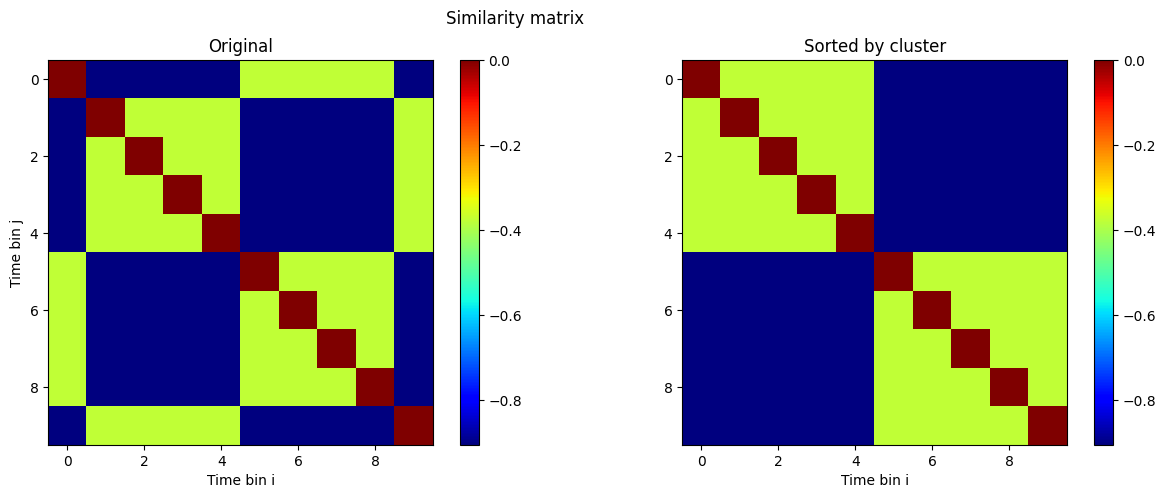

In [ ]:
distance_mat = np.array([[0, 5, 5, 5, 5, 1, 1, 1, 1, 5],
                         [5, 0, 1, 1, 1, 5, 5, 5, 5, 1],
                         [5, 1, 0, 1, 1, 5, 5, 5, 5, 1],
                         [5, 1, 1, 0, 1, 5, 5, 5, 5, 1],
                         [5, 1, 1, 1, 0, 5, 5, 5, 5, 1],
                         [1, 5, 5, 5, 5, 0, 1, 1, 1, 5],
                         [1, 5, 5, 5, 5, 1, 0, 1, 1, 5],
                         [1, 5, 5, 5, 5, 1, 1, 0, 1, 5],
                         [1, 5, 5, 5, 5, 1, 1, 1, 0, 5],
                         [5, 1, 1, 1, 1, 5, 5, 5, 5, 0]], dtype=float)

similarity_matrix = np.exp(-distance_mat / np.std(distance_mat)) -1



# X = np.array([[1, 2], [1, 4], [1, 0], [4, 2], [4, 4], [4, 0]])
X = np.array([[1, 5], [1, 6], [1, 4], [0, 5], [2, 5],
              [4, 1], [4, 0], [4, 2], [3, 1], [5, 1]])


clustering = AffinityPropagation(damping=0.9, max_iter=400, affinity='precomputed', preference=-1)
clustering.fit(similarity_matrix)

# print(similarity_matrix)
print(clustering.labels_)

sorted_matrix = sort_similarity_matrix_by_cluster(similarity_matrix, clustering.labels_)
figure_similarity_heat_map_matrices(similarity_matrix, sorted_matrix)
# print(sorted_matrix)


### Similarity mats

In [14]:
data_top_dfs = load_data(PROCESSED_DATA_TOP_PATH)
data_lateral_dfs = load_data(PROCESSED_DATA_LATERAL_PATH)

Loaded file: data-top-0.csv
Loaded file: data-top-1.csv
Loaded file: data-top-10.csv
Loaded file: data-top-11.csv
Loaded file: data-top-12.csv
Loaded file: data-top-13.csv
Loaded file: data-top-14.csv
Loaded file: data-top-15.csv
Loaded file: data-top-16.csv
Loaded file: data-top-17.csv
Loaded file: data-top-18.csv
Loaded file: data-top-19.csv
Loaded file: data-top-2.csv
Loaded file: data-top-20.csv
Loaded file: data-top-21.csv
Loaded file: data-top-22.csv
Loaded file: data-top-23.csv
Loaded file: data-top-24.csv
Loaded file: data-top-25.csv
Loaded file: data-top-26.csv
Loaded file: data-top-27.csv
Loaded file: data-top-28.csv
Loaded file: data-top-29.csv
Loaded file: data-top-3.csv
Loaded file: data-top-30.csv
Loaded file: data-top-31.csv
Loaded file: data-top-32.csv
Loaded file: data-top-33.csv
Loaded file: data-top-34.csv
Loaded file: data-top-35.csv
Loaded file: data-top-36.csv
Loaded file: data-top-37.csv
Loaded file: data-top-38.csv
Loaded file: data-top-39.csv
Loaded file: data-

In [16]:
s = get_similarity_matrix(data_top_dfs[0], data_lateral_dfs[0], get_speed_similarity, 5)

In [17]:
clusterer = AffinityPropagation(affinity='precomputed',
                                damping=0.5,
                                max_iter=800,
                                convergence_iter=10,
                                preference=-0.7,
                                verbose=True)
clusterer.fit(s)

len(set(clusterer.labels_))

Did not converge


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


1174

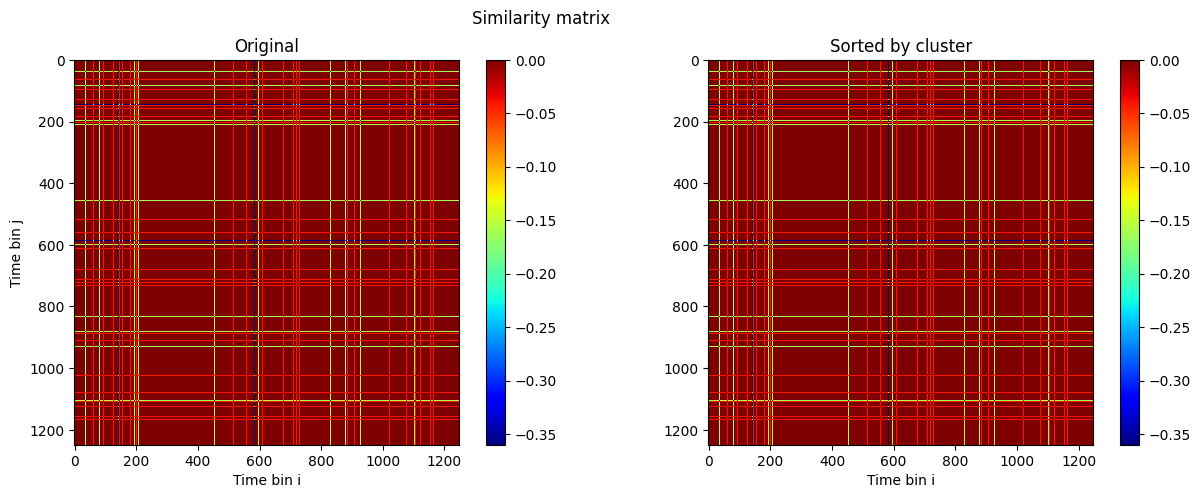

In [ ]:
sorted_matrix = sort_similarity_matrix_by_cluster(s, clusterer.labels_)
figure_similarity_heat_map_matrices(s, s)

### PCA and agglomerative clust

In [ ]:
features = initialize_features(interpolated_data_top)
features_to_analyce = features[['Rearing_amount', 'Rearing_time', 'Mean_speed',
                               'Mean_abs_aceleration']]
features_pca, pca = compute_features_pca(features_to_analyce)
assignment = compute_agg_cluster(features_pca)
# assignment = compute_random_cluster(features_pca)

assignment_check = initialize_assignment_check(features)
check_assigment(assignment_check, assignment)

NameError: name 'interpolated_data_top' is not defined

In [ ]:
# figure_scatter_features_pca(features_pca)
# figure_color_principal_components(features, pca)
# figure_pca_explained_variance(pca)

# figure_scatter_agglomerative_clusterig(features_pca, assignment)
# figure_binomial_dist()
# figure_cumulative_binomial_dist()

In [ ]:
dist = compute_method_distribution(features, iterations=1000)

In [ ]:
figure_method_dist(dist)